<a href="https://colab.research.google.com/github/sedaoturak/Quantum_Espresso_Colab/blob/main/Quantum_Espresso_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the Quantum Espresso Binary

In [1]:
%%capture
# Clone the QE git
!git clone https://github.com/QEF/q-e.git
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
# enter the q-e folder
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp
# computation time ~1 minute

Install `ase` for preparing input files, reading output files and visualization

In [2]:
%%capture
!apt install ase #computation time ~30 seconds

Run the cell to make `pw.x` binary
If you need to make any other binary like `dos.x` or `bands.x`. Replace the `pw` with `dos` or `bands`

In [3]:
%%capture 
!make pw #computation time ~5-7 minutes

Create a folder named "silicon" to download and keep all the files needed including the input files and pseudopotential files.

After creating the folder, upload the pseudopotential file in this folder.

In [4]:
# Navigating into your folder.
%cd /content/silicon/ 

/content/silicon


# Prepare the input file

In [5]:
qe_input = """
 &control
    prefix='silicon',
    ! this is a comment: you can comment out variables
    ! set pseudo_dir and outdir to suitable directories
    pseudo_dir = '/content/silicon/',
    outdir='/content/silicon/'
 /
 &system    
    ibrav=  2, celldm(1) =10.7, nat=  2, ntyp= 1,
    ecutwfc = 30.0, 
 /
 &electrons
 /
ATOMIC_SPECIES
 Si  28.086  Si.pz-vbc.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00 
 Si 0.25 0.25 0.25 
! this is a comment 
K_POINTS automatic
# this is also a comment 
   4 4 4 1 1 1
"""

# We write the input script
with open("si.scf.in", "w") as f:
    f.write(qe_input)

Visualize the silicon atoms

In [97]:
from ase import Atoms
from ase.visualize import view
input_file = ase.io.espresso.read_espresso_in('si.scf.in')

atoms = Atoms(input_file)
view(atoms,viewer='x3d')

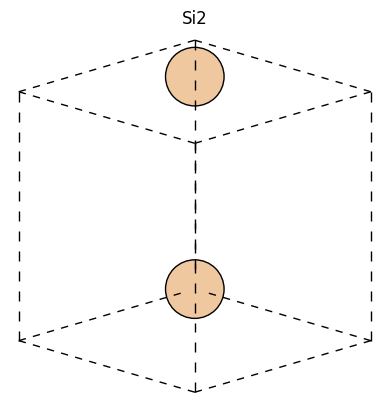

In [109]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=('45x,45y,90z'))
ax.set_title(atoms.get_chemical_formula())
ax.set_axis_off()
plt.show()

# Run the DFT code

Note: Check the directories for pseudopotential file and output file!

In [6]:
! /content/q-e/bin/pw.x  -in si.scf.in > si.scf.out

# See the output file

In [7]:
!cat si.scf.out


     Program PWSCF v.7.2 starts on 10Jun2023 at 12: 6:58 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       2 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                     2

     MPI processes distributed on     1 nodes
     7416 MiB available memory on the printing compute node when the environment starts

     Reading input from si.scf.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (nty

In [8]:
!grep -e "total energy" -e estimate si.scf.out

     total energy              =     -15.83474059 Ry
     estimated scf accuracy    <       0.04725160 Ry
     total energy              =     -15.83654591 Ry
     estimated scf accuracy    <       0.00215073 Ry
     total energy              =     -15.83684221 Ry
     estimated scf accuracy    <       0.00004787 Ry
!    total energy              =     -15.83687864 Ry
     estimated scf accuracy    <       0.00000003 Ry
     The total energy is the sum of the following terms:


In [10]:
import ase.io
output = ase.io.read("/content/silicon/si.scf.out")
output.get_total_energy()

-215.47169195270104

# Convergence test

In [116]:
import numpy as np
cutoff_energies = np.arange(20,110,10)
cutoff_index = qe_input.find('ecutwfc = ') + 10
total_energies = []
for cutoff in cutoff_energies:
  new_input_file = qe_input[:cutoff_index] + str(cutoff) + qe_input[cutoff_index+4:]
  with open("si.scf.in", "w") as f:
    f.write(new_input_file)
  ! /content/q-e/bin/pw.x  -in si.scf.in > si.scf.out
  output = ase.io.read("/content/silicon/si.scf.out")
  total_energies.append(output.get_total_energy())

# computation time: 40 seconds

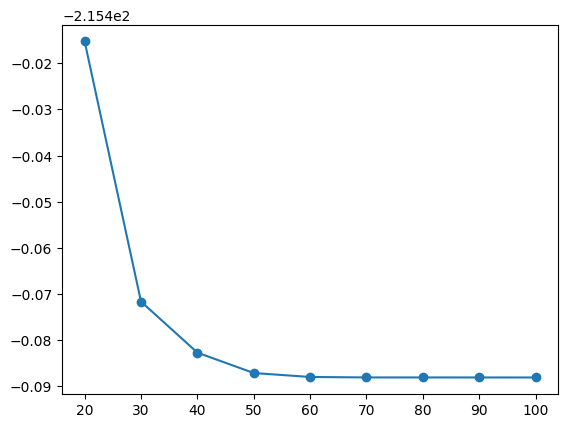

In [117]:
import matplotlib.pyplot as plt

plt.plot(cutoff_energies, total_energies,'o-')